In [9]:
# Importación de librerías 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
# Seteo para que no se muestre notación científica
np.set_printoptions(suppress=True)
# Saco los warnings
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Levanto el dataset
url = 'https://raw.githubusercontent.com/xlisouski/DataCoder/main/train.csv'
df = pd.read_csv(url, sep = ',')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
# Procesamiento 

# Renombres
df = df.rename(columns={'1stFlrSF': 'V_1stFlrSF'})
df = df.rename(columns={'2ndFlrSF': 'V_2ndFlrSF'})
df = df.rename(columns={'3SsnPorch': 'V_3SsnPorch'})

# Construccion binarias
df['MSSubClass_Es1Piso'] = np.where(df['MSSubClass'].isin([20, 30, 40, 120]),1,0)
df['MSSubClass_Es2Pisos'] = np.where(df['MSSubClass'].isin([60, 70, 160, 75]),1,0)
df['MSZoning_RL'] = np.where(df['MSZoning'].isin(['RL']),1,0)
df['MSZoning_FV'] = np.where(df['MSZoning'].isin(['FV']),1,0)
df['Alley_Pave'] = np.where(df['Alley'].isin(['Pave']),1,0)
df['MasVnrType_Stone'] = np.where(df['MasVnrType'].isin(['Stone']),1,0)
df['MasVnrType_BrkFace'] = np.where(df['MasVnrType'].isin(['BrkFace']),1,0)

# Variables factor tiempo 
df['Antig_Viv'] = df['YrSold'] - df['YearBuilt']
df['Antig_Rem'] = np.where( df['YearRemodAdd'] > df['YrSold'],
                            df['YrSold'] - df['YearBuilt'],
                            df['YrSold'] - df['YearRemodAdd'])
df['Antig_Garage'] = np.where((df['GarageYrBlt'] > df['YrSold']) | (df['GarageYrBlt'].isnull()),
                            999,
                            df['YrSold'] - df['GarageYrBlt'])

df['Garage_MuyNvo'] = np.where(df['Antig_Garage'] < 3,1,0)
df['Garage_Nvo'] = np.where((df['Antig_Garage'] >= 3) & (df['Antig_Garage'] < 20),1,0)
df['Garage_SemiNvo'] = np.where((df['Antig_Garage'] >= 20) & (df['Antig_Garage'] < 40),1,0)

# Normalizamos los datos
from sklearn.preprocessing import StandardScaler

# Selecciono las variables no binarias
features_no_bin = ['GrLivArea','GarageArea','GarageCars','OverallQual','LotArea',
            'OverallCond','V_1stFlrSF','V_2ndFlrSF','V_3SsnPorch','BsmtFullBath',
            'BsmtHalfBath','FullBath','Antig_Viv', 'Antig_Rem',
            'SalePrice']


X_train = df[features_no_bin].values

# Defino escalador
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

# Genero df
df_scaled = pd.DataFrame(data = X_train)
prefijo = "Scaled_"
df_scaled.columns = features_no_bin
df_scaled.add_prefix(prefijo)
df_scaled = df_scaled.add_prefix(prefijo)

# Genero dataset para modelar
features_bin = [ 'MSSubClass_Es1Piso', 'MSSubClass_Es2Pisos',
            'MSZoning_RL', 'MSZoning_FV', 'Alley_Pave', 'MasVnrType_Stone', 'MasVnrType_BrkFace', 
             'Garage_MuyNvo', 'Garage_Nvo', 'Garage_SemiNvo']

df_train_final = pd.concat([df_scaled,df[features_bin]],axis = 1)

df_train_final.head()

,Scaled_GrLivArea,Scaled_GarageArea,Scaled_GarageCars,Scaled_OverallQual,Scaled_LotArea,Scaled_OverallCond,Scaled_V_1stFlrSF,Scaled_V_2ndFlrSF,Scaled_V_3SsnPorch,Scaled_BsmtFullBath,...,MSSubClass_Es1Piso,MSSubClass_Es2Pisos,MSZoning_RL,MSZoning_FV,Alley_Pave,MasVnrType_Stone,MasVnrType_BrkFace,Garage_MuyNvo,Garage_Nvo,Garage_SemiNvo
0,0.370333,0.351000,0.311725,0.651479,-0.207142,-0.517200,-0.793434,1.161852,-0.116339,1.107810,...,0,1,1,0,0,0,1,0,1,0
1,-0.482512,-0.060731,0.311725,-0.071836,-0.091886,2.179628,0.257140,-0.795163,-0.116339,-0.819964,...,1,0,1,0,0,0,0,0,0,1
2,0.515013,0.631726,0.311725,0.651479,0.073480,-0.517200,-0.627826,1.189351,-0.116339,1.107810,...,0,1,1,0,0,0,1,0,1,0
3,0.383659,0.790804,1.650307,0.651479,-0.096897,-0.517200,-0.521734,0.937276,-0.116339,1.107810,...,0,1,1,0,0,0,0,0,1,0
4,1.299326,1.698485,1.650307,1.374795,0.375148,-0.517200,-0.045611,1.617877,-0.116339,1.107810,...,0,1,1,0,0,0,1,0,1,0


In [146]:
# Reordeno aleatoriamente
df_train_final = df_train_final.sample(frac=1, random_state=42)
df_train_final.head()

,Scaled_GrLivArea,Scaled_GarageArea,Scaled_GarageCars,Scaled_OverallQual,Scaled_LotArea,Scaled_OverallCond,Scaled_V_1stFlrSF,Scaled_V_2ndFlrSF,Scaled_V_3SsnPorch,Scaled_BsmtFullBath,...,MSSubClass_Es1Piso,MSSubClass_Es2Pisos,MSZoning_RL,MSZoning_FV,Alley_Pave,MasVnrType_Stone,MasVnrType_BrkFace,Garage_MuyNvo,Garage_Nvo,Garage_SemiNvo
892,-0.851824,-0.977769,-1.026858,-0.071836,-0.210750,2.179628,-0.244858,-0.795163,-0.116339,-0.819964,...,1,0,1,0,0,0,0,0,0,0
1105,2.106483,1.118318,0.311725,1.374795,0.174303,-0.517200,0.872994,1.775997,-0.116339,1.107810,...,0,1,1,0,0,0,1,0,1,0
413,-0.927971,-0.528608,0.311725,-0.795151,-0.156028,0.381743,-0.348363,-0.795163,-0.116339,-0.819964,...,1,0,0,0,0,0,0,0,0,0
522,0.282764,-0.247882,0.311725,-0.071836,-0.552908,1.280685,-0.410466,0.717284,-0.116339,-0.819964,...,0,0,0,0,0,0,0,0,0,0
1036,0.199003,2.054071,1.650307,2.098110,0.238646,-0.517200,1.183509,-0.795163,-0.116339,1.107810,...,1,0,1,0,0,1,0,1,0,0


# Intento 1: Problema de Varianza
Un posible problema en la varianza del modelo significa que las métricas de validación en distintas submuestras es muy diferente, por lo que podríamos tener problemas de **Generalización**. 

In [210]:
# Obtengo data en values
X = df_train_final.drop(columns='Scaled_SalePrice').values
y = df_train_final['Scaled_SalePrice'].values

# Librerias
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Crear el modelo
model = RandomForestRegressor(random_state = 42, 
                              n_estimators = 10,
                              max_depth = 100,
                              max_features = 25,
                              min_samples_leaf = 1)

k_elegido = 10

scores = cross_val_score(model, X, y, cv=k_elegido, scoring='r2')

scores_df = pd.DataFrame({'K_orden': range(1,k_elegido+1),
                          'Scores' : scores})

scores_df

,K_orden,Scores
0,1,0.894551
1,2,0.887837
2,3,0.889684
3,4,0.885842
4,5,0.665823
5,6,0.837032
6,7,0.851974
7,8,0.830797
8,9,0.838514
9,10,0.896456


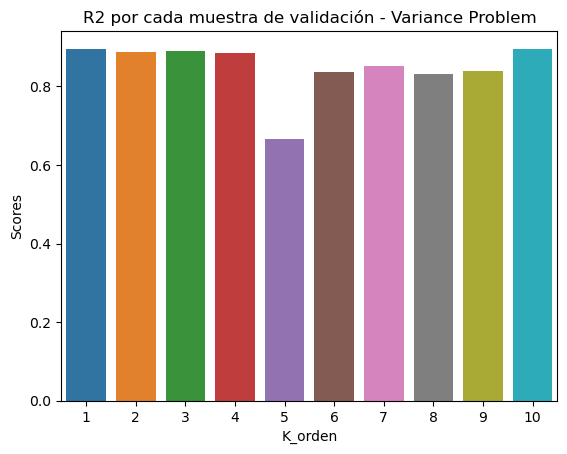

In [211]:
# Visualmente
plt.figure()
sns.barplot(data = scores_df,
              x = 'K_orden',
              y = 'Scores')
plt.title('R2 por cada muestra de validación - Variance Problem')
plt.show()

In [212]:
# Metricas
media_1 = scores_df['Scores'].mean()
desvio_1 = scores_df['Scores'].std()

print('R2 Promedio: ', round(media_1,4))
print('R2 Desvio: ', round(desvio_1,4))
print('R2 CV: ', round(desvio_1 / media_1,4))

R2 Promedio:  0.8479
R2 Desvio:  0.0691
R2 CV:  0.0815


# Intento 2: Problema de Sesgo
Un posible problema en el sesgo del modelo significa que el modelo no es lo suficientemente complejo como para capturar las verdaderas relaciones, así que estoy ante un caso de **Underfitting**. 

In [213]:
# Obtengo data en values
X = df_train_final.drop(columns='Scaled_SalePrice').values
y = df_train_final['Scaled_SalePrice'].values

# Librerias
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Crear el modelo
model = RandomForestRegressor(random_state = 42, 
                              n_estimators = 100,
                              max_depth = 2,
                              max_features = 10,
                              min_samples_leaf = 45)

k_elegido = 2

scores = cross_val_score(model, X, y, cv=k_elegido, scoring='r2')

scores_df = pd.DataFrame({'K_orden': range(1,k_elegido+1),
                          'Scores' : scores})

scores_df

,K_orden,Scores
0,1,0.669150
1,2,0.671255


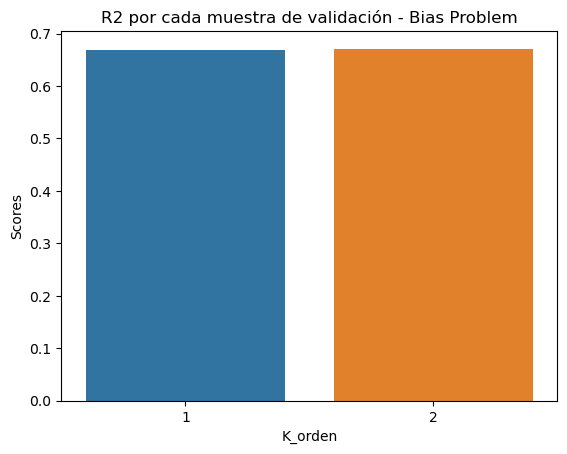

In [214]:
# Visualmente
plt.figure()
sns.barplot(data = scores_df,
              x = 'K_orden',
              y = 'Scores')
plt.title('R2 por cada muestra de validación - Bias Problem')
plt.show()

In [215]:
# Metricas
media_2 = scores_df['Scores'].mean()
desvio_2 = scores_df['Scores'].std()

print('R2 Promedio: ', round(media_2,4))
print('R2 Desvio: ', round(desvio_2,4))
print('R2 CV: ', round(desvio_2 / media_2,4))

R2 Promedio:  0.6702
R2 Desvio:  0.0015
R2 CV:  0.0022


# Intento 3: Intentando resolver ambos problemas
Veamos de elegir hiperparámetros que maximicen las métricas, y minimicen la varianza. 

In [216]:
# Obtengo data en values
X = df_train_final.drop(columns='Scaled_SalePrice').values
y = df_train_final['Scaled_SalePrice'].values

# Librerias
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Crear el modelo
model = RandomForestRegressor(random_state = 42, 
                              n_estimators = 100,
                              max_depth = 6,
                              max_features = 9,
                              min_samples_leaf = 20)

k_elegido = 4

scores = cross_val_score(model, X, y, cv=k_elegido, scoring='r2')

scores_df = pd.DataFrame({'K_orden': range(1,k_elegido+1),
                          'Scores' : scores})

scores_df

,K_orden,Scores
0,1,0.807727
1,2,0.786460
2,3,0.777491
3,4,0.837181


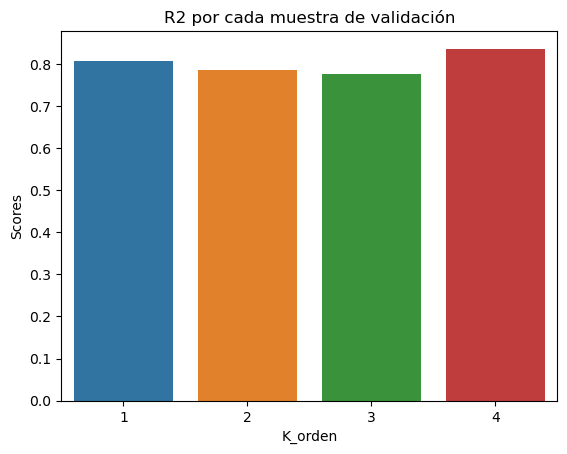

In [217]:
# Visualmente
plt.figure()
sns.barplot(data = scores_df,
              x = 'K_orden',
              y = 'Scores')
plt.title('R2 por cada muestra de validación')
plt.show()

In [218]:
# Metricas
media_3 = scores_df['Scores'].mean()
desvio_3 = scores_df['Scores'].std()

print('R2 Promedio: ', round(media_3,4))
print('R2 Desvio: ', round(desvio_3,4))
print('R2 CV: ', round(desvio_3 / media_3,4))

R2 Promedio:  0.8022
R2 Desvio:  0.0265
R2 CV:  0.0331


In [223]:
# En cuánto resolvimos el problema? 
print('Varianza')
print('Coeficiente de Variación R2 - Intento 1: ', round(desvio_1 / media_1,4))
print('Coeficiente de Variación R2 - Intento 3: ', round(desvio_3 / media_3,4))
print('Mejora: ', round(((desvio_3 / media_3) / (desvio_1 / media_1) - 1 ) * 100), '%')

print('')

print('Bias')
print('Promedio R2 - Intento 2: ', round(media_2,4))
print('Promedio R2 - Intento 3: ', round(media_3,4))
print('Mejora: ', round(((media_3) / (media_2) - 1 ) * 100), '%')

Varianza
Coeficiente de Variación R2 - Intento 1:  0.0815
Coeficiente de Variación R2 - Intento 3:  0.0331
Mejora:  -59 %

Bias
Coeficiente de Variación R2 - Intento 2:  0.6702
Coeficiente de Variación R2 - Intento 3:  0.8022
Mejora:  20 %
